# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Lectura y tratamiento de datos
Se leen todos los archivos correspondientes a los precios y se calcula el precio promedio diario para cada fecha

In [2]:
Lista_promedios = []

for anio in range(1995,2019):
  if anio > 2015:
    Nombre_Archivo = './datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(anio)+'.xls'
  else:
    Nombre_Archivo = './datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(anio)+'.xlsx'

  #Leer cada archivo de excel
  archivo= pd.ExcelFile(Nombre_Archivo)
  #leer la hoja excel de cada archivo
  hoja = archivo.parse(header=2,usecols=[x for x in range(25)])
  #Eliminar filas nulas
  hoja = hoja.dropna()
  #Eliminar fechas repetidas
  Hoja = hoja.drop_duplicates(subset ="Fecha", 
                     keep = False, inplace = True)

  #Promedio diario de precio
  fechas_hoja = hoja['Fecha']
  fechas_hoja = pd.to_datetime(fechas_hoja)
  promedios = hoja.mean(axis=1,numeric_only=True,skipna=True)
  dataframe_archivo = pd.DataFrame({'Fecha':fechas_hoja,'Promedio':promedios})
  Lista_promedios.append(dataframe_archivo)
dataframe_datos = pd.concat(Lista_promedios)

  

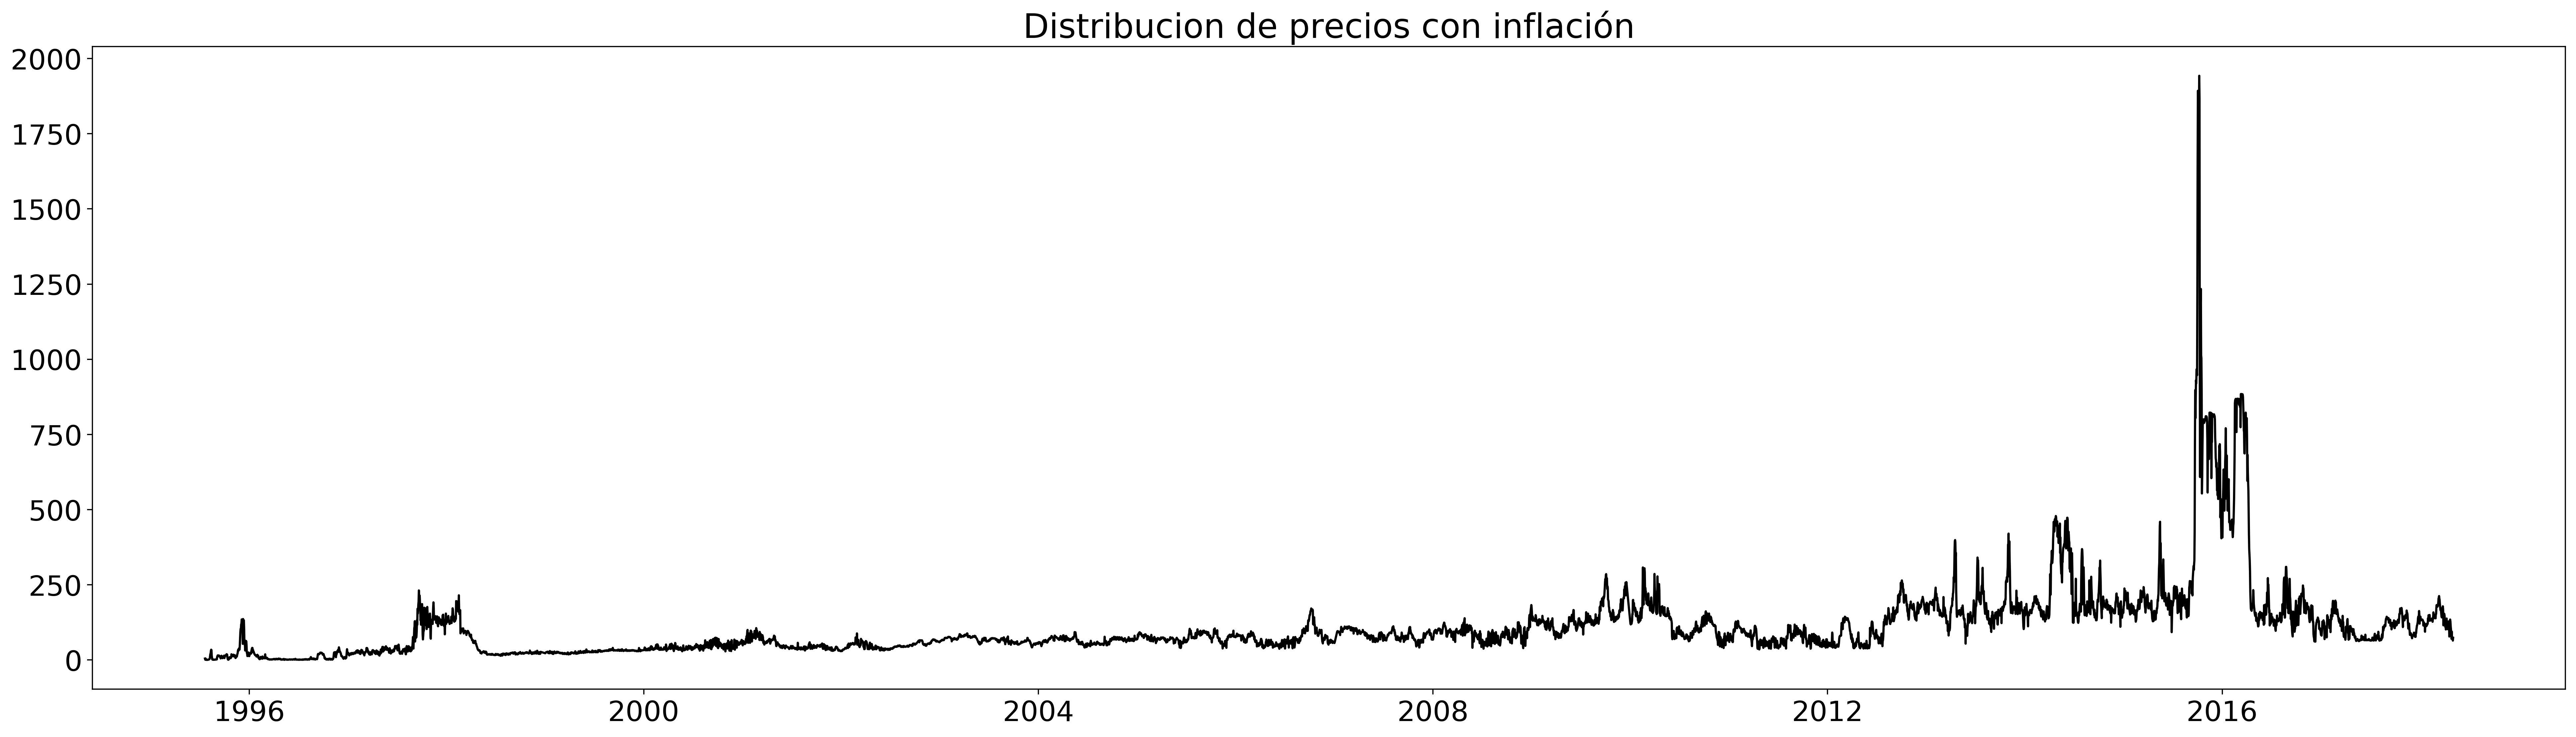

In [3]:
figure(num=None, figsize=(30,8), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.title("Distribucion de precios con inflación")
plt.plot(dataframe_datos["Fecha"], dataframe_datos["Promedio"],label="precio",color="black")

## Lectura IPC y obtención del índice para deflactar
Leermos el archivo que tiene los datos del IPC, eliminamos manualmente los datos que no nos sirven. Generamos un nuevo Dataframe con la fecha, y el IPC, con estos datos, calculamos el índice para deflactar los precios.
Se toma como fecha base 2018-05-01 (índice 100).

In [4]:
#Leer archivo excel
archivo_IPC= pd.ExcelFile('./datos/IPC.xlsx')
#leer la hoja excel
hoja_IPC = archivo_IPC.parse('IPC',header=12,usecols=[0,3])
#Eliminar filas nulas
hoja_IPC = hoja_IPC.dropna()

fechas = hoja_IPC['Año(aaaa)-Mes(mm)']
fechas_IPC = pd.to_datetime(fechas)
IPC_mensual = hoja_IPC['Inflación mensual']

Dataframe_Ipc = pd.DataFrame({'Fecha':fechas_IPC,'Ipc':IPC_mensual})

#Hallamos el índice para deflactar los datos
#tomamos como 100 el dato mas actual, es decir, el mes 5 del año 2018
Lista_indices = []
for indice_fila, fila in Dataframe_Ipc.iterrows():
  if indice_fila == 0:
    Lista_indices.append(100)
  else:
    indice = Lista_indices[indice_fila-1]/(1+fila['Ipc'])
    Lista_indices.append(indice)
Dataframe_Ipc['indice_actual'] = Lista_indices
Dataframe_Ipc.set_index('Fecha')
Dataframe_Ipc

,Fecha,Ipc,indice_actual
0,2018-05-01,0.0025,100.000000
1,2018-04-01,0.0046,99.542106
2,2018-03-01,0.0024,99.303777
3,2018-02-01,0.0071,98.603691
4,2018-01-01,0.0063,97.986377
...,...,...,...
270,1995-11-01,0.0079,21.705888
271,1995-10-01,0.0088,21.516543
272,1995-09-01,0.0084,21.337309
273,1995-08-01,0.0063,21.203726


## Deflactación de precios

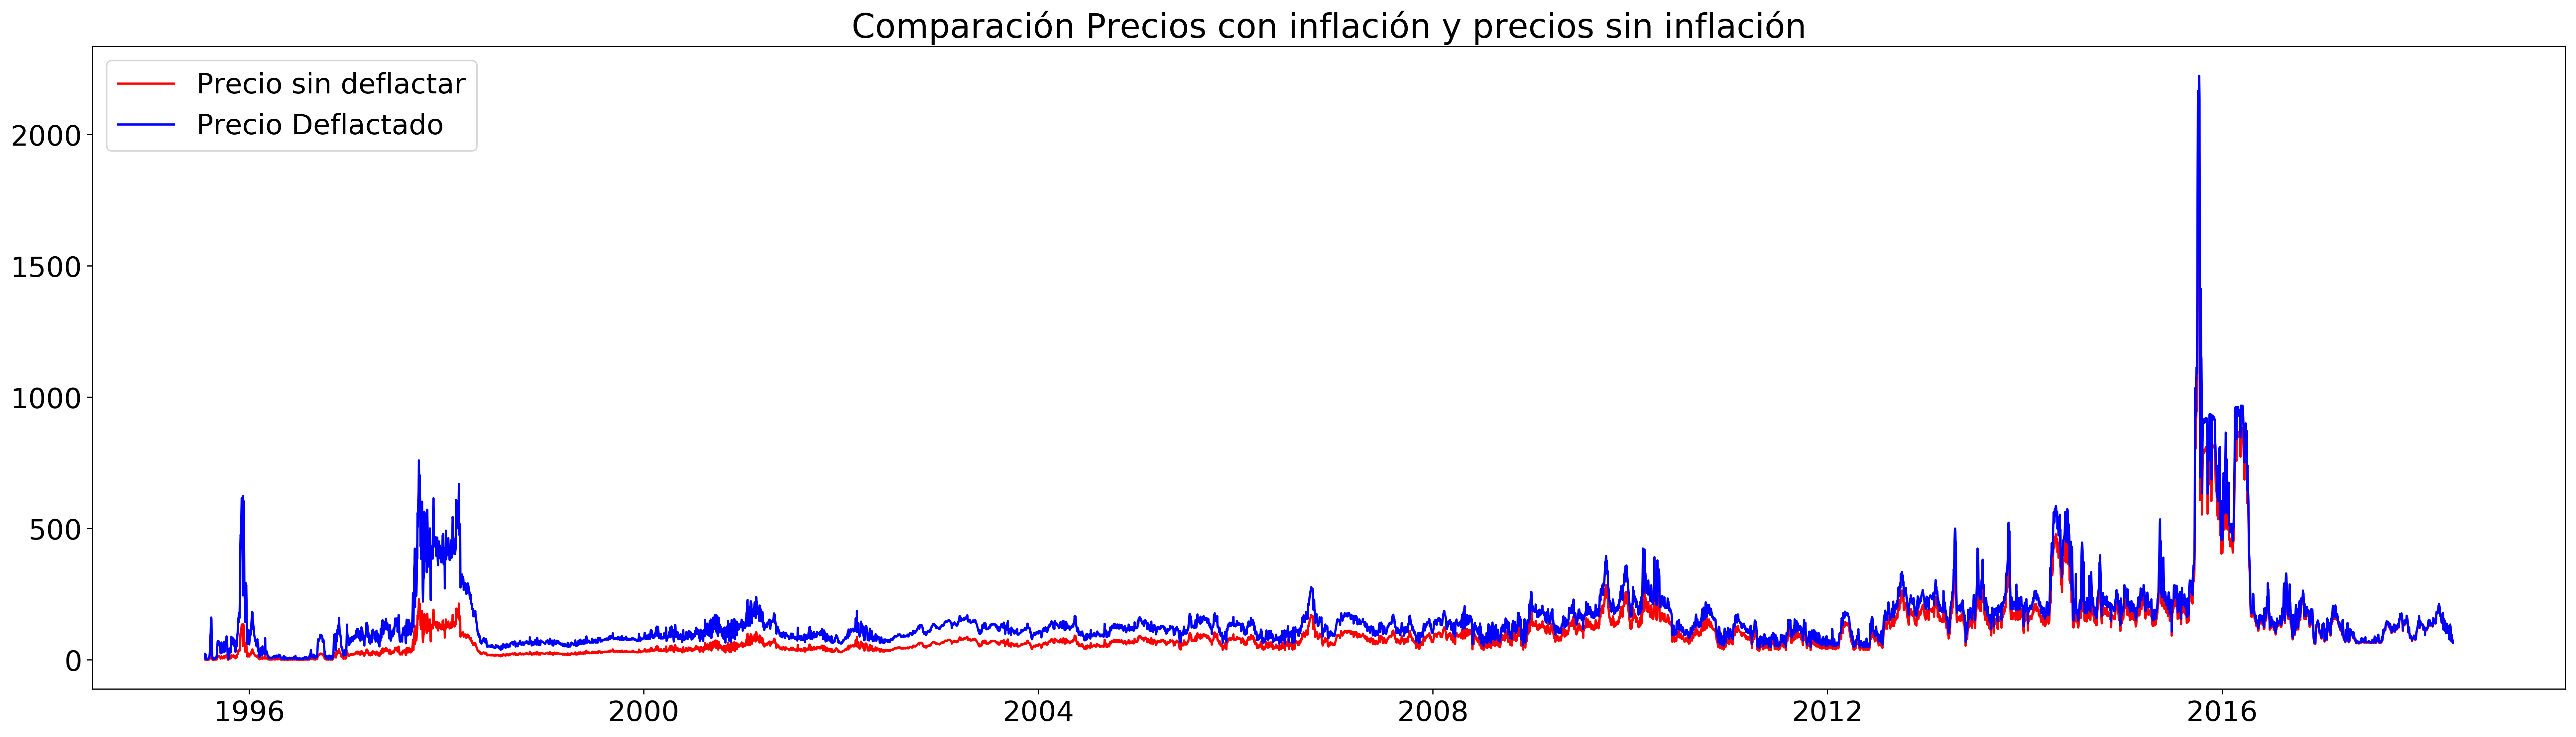

In [5]:
#Deflactamos los datos
#for indice_fila,fila in  dataframe_datos.iterrows():
copia = dataframe_datos.copy()
copia_ipc = Dataframe_Ipc.copy()


for indice,indice_fila in copia_ipc.iterrows():
  copia.reset_index(drop=True, inplace = True)
  copia.loc[(copia["Fecha"].dt.year == indice_fila["Fecha"].year) & (copia["Fecha"].dt.month  ==  indice_fila["Fecha"].month),"Promedio"] = (copia["Promedio"]/indice_fila["indice_actual"])*100

una_fecha = pd.Timestamp('2018-01-01T12')
figure(num=None, figsize=(30,8), dpi=320)
plt.rcParams.update({'font.size': 19})
plt.title("Comparación Precios con inflación y precios sin inflación")
plt.plot(dataframe_datos["Fecha"], dataframe_datos["Promedio"],label="Precio sin deflactar",color="red")
plt.plot(copia["Fecha"],copia["Promedio"],label="Precio Deflactado",color="blue")
plt.legend()

## Transformacion de los datos
#### Utilizamos los siguientes tipos de transformación
* $ \sqrt{x} $
* $ \sqrt[3]{x} $
* $ log(x)  $

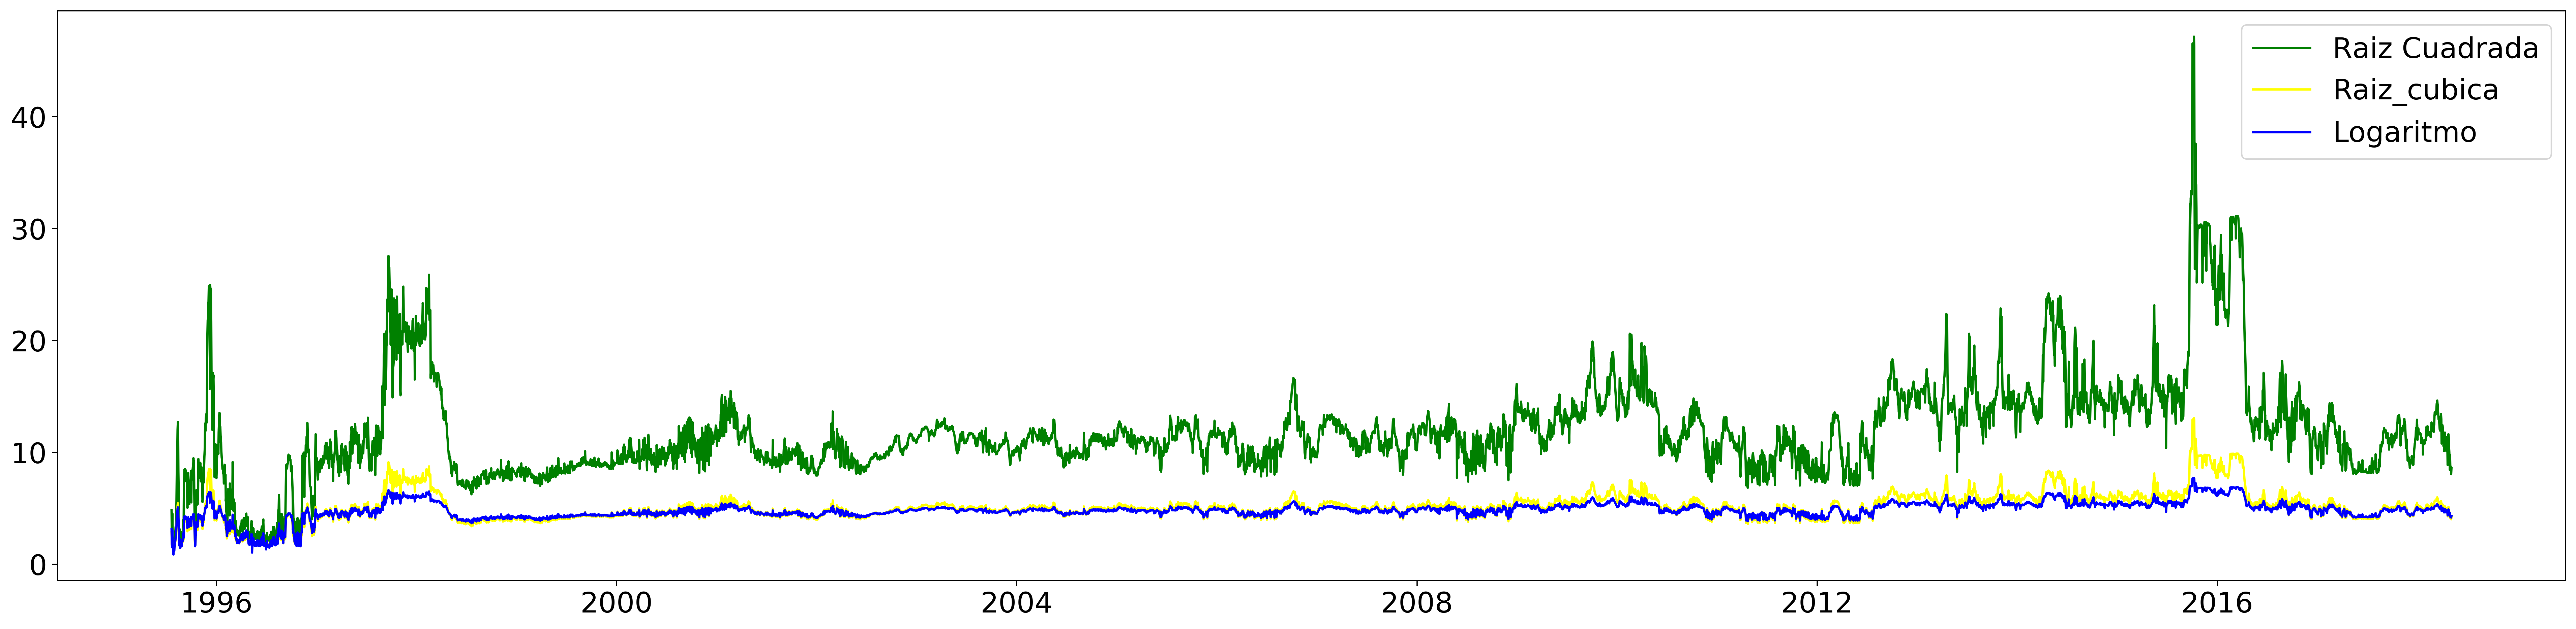

In [6]:
#Transformaciones de los datos
#Creamos varias columnas en el dataframe con distintos tipos de transformaciones
copia["Raiz_cuadrada"] = np.sqrt(copia["Promedio"])
copia["Raiz_cubica"] = np.cbrt(copia["Promedio"])
copia["logaritmo"] = np.log(copia["Promedio"])
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.plot(copia["Fecha"],copia["Raiz_cuadrada"],label="Raiz Cuadrada",color="green")
plt.plot(copia["Fecha"],copia["Raiz_cubica"],label="Raiz_cubica",color="yellow")
plt.plot(copia["Fecha"],copia["logaritmo"],label="Logaritmo",color="blue")
plt.legend()

###### Se agrega el código para el Adaline al cuál se le agrega el momentum como parámetro

In [7]:
class Adaline:
    
    def __init__(self,
                 learning_rate=0.001,
                 max_epochs=100,      
                 shuffle=False,       
                 random_state=None,   
                 warm_start=False,    
                 momentum=0):         
        #parametros
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
        self.momentum=momentum

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]+(self.momentum*self.coef_) 
                self.intercept_ += 2 * self.learning_rate * e+(self.momentum*self.intercept_) 
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

###### Hacemos partición de los datos, dejando los últimos 7 para pronostico

In [8]:
datos_entrenamiento = copia[:-7]
datos_pronostico = copia[-7:]
datos_pronostico

,Fecha,Promedio,Raiz_cuadrada,Raiz_cubica,logaritmo
8256,2018-04-29,70.919756,8.421387,4.139257,4.261549
8257,2018-04-30,95.123181,9.753111,4.564874,4.555173
8258,2018-05-01,71.666726,8.465620,4.153739,4.272027
8259,2018-05-02,76.374441,8.739247,4.242769,4.335648
8260,2018-05-03,71.148348,8.434948,4.143700,4.264767
8261,2018-05-04,64.710120,8.044260,4.014740,4.169918
8262,2018-05-05,73.972085,8.600703,4.197808,4.303688


In [9]:
def inversa(datos,tipo):
  #tipo 0: sin transformacion
  #tipo 1: Raiz cuadrada
  #tipo 2: Raiz Cúbica
  #Tipo 3: Logaritmo natural
  if tipo == 1:
    return np.sqrt(datos)
  elif tipo == 2:
    return np.power(datos,3)
  elif tipo == 3:
    return np.exp(datos)
  else:
    return datos


#funcion que se encarga de encontrar cada uno de los parámetros a optimizar

def evaluar_modelo(datos,tipo,datos_prediccion):
    
    #Escalamiento de datos

    posiblesModelos = pd.DataFrame(columns = ["Error de pronostico","Error de entrenamiento","Rezagos/L","Momentum","Tasa de aprendizaje","Pronostico_entrenamiento","Pronostico_prediccion"])
    escalado = MinMaxScaler()
    d=np.asarray(datos).reshape(-1,1)
    escalado.fit(d)
    d=escalado.transform(d).ravel()

    #Rezafos
    for L in range(7,13):
      #tasa de aprendizaje
        for tasaAprendizaje in np.arange(0.005, 0.1, 0.001):
          #Momentum
            for momentum in np.arange(0.00000, 0.0001,0.00002):
                
                #Se Construye el adaline
                X = []
                for t in range(L,len(d)):
                    X.append(d[t-L:t].copy())
                adaline = Adaline(
                    learning_rate=tasaAprendizaje, 
                    max_epochs=1,                  
                    shuffle=False,                 
                    random_state=123,              
                    warm_start=False,              
                    momentum = momentum)            
                errors2, forecasts = adaline.fit(
                    X, 
                    d[L:])
                
                #se pronostica el modelo entrenado
                Pronosticados = []
                for i in range(0,7):
                    nuevaPrediccion = adaline.predict(X[-1])
                    proximo = np.append(X[-1][1:L], [nuevaPrediccion])
                    X = np.concatenate( ( X, [proximo] ), axis=0) 
                    Pronosticados.append(nuevaPrediccion[0])

                #Se invierten las transformaciones y los datos
                Pronosticados = escalado.inverse_transform(np.asarray(Pronosticados).reshape(-1,1)).ravel() 
                forecasts = escalado.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()
                Pronosticados = inversa(Pronosticados,tipo)
                forecasts = inversa(forecasts,tipo)
                errorPronostico = np.sum(np.power(np.array(datos_prediccion) - Pronosticados, 2))   
                sumaErrores = np.sum(errors2)
                posiblesModelos = posiblesModelos.append({
                    "Error de pronostico": errorPronostico,
                    "Error de entrenamiento": sumaErrores,
                    "Rezagos/L": L,
                    "Momentum": momentum,
                    "Tasa de aprendizaje": tasaAprendizaje,
                    "Pronostico_entrenamiento":forecasts,
                    "Pronostico_prediccion":Pronosticados
                },ignore_index=True)

    return posiblesModelos



In [10]:
#Sin transformacion
sin_transformacion = evaluar_modelo(datos_entrenamiento["Promedio"],0,datos_pronostico["Promedio"])
sin_transformacion

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
0,1.211704e+04,21.646537,7,0.00000,0.005,"[734.377090582212, 703.0420337013426, 700.8537...","[101.91681892727112, 126.30071989459367, 125.7..."
1,1.832316e+04,24.278155,7,0.00002,0.005,"[659.6296813438628, 669.060432290168, 656.3838...","[116.62008103221586, 137.08408470122893, 142.1..."
2,1.811140e+05,90.044700,7,0.00004,0.005,"[1829.2089307549743, 1793.9408375879887, 1779....","[103.74891319982544, 82.66420158780132, 91.143..."
3,6.930255e+04,105.399591,7,0.00006,0.005,"[-562.0410985646246, -573.3320236877473, -565....","[166.79583639660157, 85.3107020466786, 122.945..."
4,3.803983e+07,299.594535,7,0.00008,0.005,"[-1765.8481262247483, -1784.589501559069, -176...","[10.18079647760774, -106.77298664972568, -277...."
...,...,...,...,...,...,...,...
2845,1.242294e+04,4.053102,12,0.00000,0.099,"[-396.6716282437013, -302.8991859072358, -240....","[139.35013148198402, 113.58259054788613, 98.78..."
2846,6.576229e+04,12.645795,12,0.00002,0.099,"[1877.48145847355, 1500.9334484576013, 1183.73...","[80.01309310157741, 63.58352077859892, 76.1877..."
2847,2.262523e+04,14.145407,12,0.00004,0.099,"[1361.8436822567812, 1102.8092788300557, 882.8...","[74.83052396710337, 104.91247143262264, 84.183..."
2848,8.939385e+04,9.722217,12,0.00006,0.099,"[-658.9153306137171, -516.4141039357403, -386....","[89.15468288035598, 142.67534807735402, 193.00..."


#### Obtenemos modelo con menor error para los datos sin transformación

In [11]:
mejor_sin_transformacion = sin_transformacion[sin_transformacion['Error de pronostico'] == sin_transformacion['Error de pronostico'].min()]
mejor_sin_transformacion

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
2012,1262.604662,11.34774,11,0.00004,0.027,"[1131.9291273142862, 1082.822742400164, 1018.3...","[91.36114268350232, 100.77705890096058, 71.499..."


In [14]:
#Para Raiz_cuadrada
modelo_Raiz_cuadrada = evaluar_modelo(datos_entrenamiento["Raiz_cuadrada"],1,datos_pronostico["Raiz_cuadrada"])
modelo_Raiz_cuadrada

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Jhonier\anaconda3\lib\site-packages\ipykernel_launcher.py:7:

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
0,184.826957,40.143048,7,0.00000,0.005,"[4.923146884187667, 5.173074144784006, 5.24603...","[3.5041326209492394, 3.8157682736692315, 3.418..."
1,205.747715,16.761489,7,0.00002,0.005,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.143078544154318, 3.1679317178850743, 3.3730..."
2,185.242320,32.566023,7,0.00004,0.005,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.436032827761735, 3.4557668353096096, 3.3369..."
3,129.224284,77.665687,7,0.00006,0.005,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.586738183702815, 4.091558082927018, 4.44622..."
4,NaN,75.498069,7,0.00008,0.005,"[6.650893547634741, 6.558436446131829, 6.63177...","[3.106229194176753, 3.6218664391883513, 2.9637..."
...,...,...,...,...,...,...,...
2845,212.937474,13.041839,12,0.00000,0.099,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.3339186584734546, 2.9671258805868397, 2.979..."
2846,202.965906,12.106371,12,0.00002,0.099,"[nan, 0.7369995644977225, 2.3902134792835814, ...","[3.104384005365823, 3.241382292557084, 3.37078..."
2847,230.321839,17.044477,12,0.00004,0.099,"[6.1561335629827765, 5.331249005257273, 5.0994...","[3.022467902975487, 3.1329816426892125, 2.8847..."
2848,256.933219,18.288055,12,0.00006,0.099,"[4.244466379742977, 3.1504894555930063, 2.6968...","[2.9791337061460137, 2.2090288525846105, 1.608..."


###### Obtenemos modelo con menor error para la transformación Raíz cuadrada

In [15]:
mejor_Raiz_cuadrada = modelo_Raiz_cuadrada[modelo_Raiz_cuadrada['Error de pronostico'] == modelo_Raiz_cuadrada['Error de pronostico'].min()]
mejor_Raiz_cuadrada

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
2619,72.044165,37.155801,12,0.00008,0.053,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.4193572566699375, 4.351327072024387, 5.4349..."


In [18]:
#Para Raiz_cubica
modelo_Raiz_cubica = evaluar_modelo(datos_entrenamiento["Raiz_cubica"],2,datos_pronostico["Raiz_cubica"])

###### Obtenemos modelo con menor error para la transformación Raíz cúbica

In [19]:
mejor_Raiz_cubica = modelo_Raiz_cubica[modelo_Raiz_cubica['Error de pronostico'] == modelo_Raiz_cubica['Error de pronostico'].min()]
mejor_Raiz_cubica

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
504,2168.921177,31.724136,8,0.00008,0.01,"[376.1348585464912, 475.8342129296169, 341.934...","[42.386131160187176, 12.728870977061124, 2.367..."


In [20]:
#Para logaritmo natural
modelo_logaritmo = evaluar_modelo(datos_entrenamiento["logaritmo"],3,datos_pronostico["logaritmo"])
modelo_logaritmo

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
0,7.051175e+04,33.358494,7,0.00000,0.005,"[0.014490776073062124, 0.0357106088769807, 0.0...","[105.2872828708258, 118.66642729482459, 111.87..."
1,8.137816e+04,23.979033,7,0.00002,0.005,"[38.587394825640274, 5.44170268719947, 1.81139...","[126.76444959380578, 92.93375442307497, 109.39..."
2,9.762050e+04,137.292419,7,0.00004,0.005,"[9.789925497856449e-05, 0.0007211641740212356,...","[123.39120423093469, 109.14826410140637, 129.5..."
3,3.719443e+05,41.447922,7,0.00006,0.005,"[0.47443536801223557, 0.19511596430738476, 0.5...","[65.11160122375138, 60.12504131408532, 73.8341..."
4,6.375584e+06,122.753766,7,0.00008,0.005,"[0.01544701715776647, 0.01932539759979213, 0.0...","[360.0328146402557, 333.26624863020714, 136.02..."
...,...,...,...,...,...,...,...
2845,6.995742e+04,104.654671,12,0.00000,0.099,"[183.87616236658272, 291.976449177982, 6.53308...","[89.5806889788691, 94.86675084347576, 126.0636..."
2846,1.301817e+05,33.453689,12,0.00002,0.099,"[2235.9541495983403, 6204.283410281352, 551.92...","[90.48572187307795, 125.98836485236411, 199.07..."
2847,9.653548e+04,43.289756,12,0.00004,0.099,"[17.798358182875337, 19.274621289442038, 1.690...","[90.00739395480011, 158.1076779265364, 116.363..."
2848,2.166766e+04,1504.228249,12,0.00006,0.099,"[68.03424396958656, 153.16809825786595, 47.382...","[90.49403549665745, 70.80471929904344, 66.0692..."


###### Obtenemor modelo con menor error para la transformación logaritmo natural

In [21]:
mejor_logaritmo = modelo_logaritmo[modelo_logaritmo['Error de pronostico'] == modelo_logaritmo['Error de pronostico'].min()]
mejor_logaritmo

,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje,Pronostico_entrenamiento,Pronostico_prediccion
1019,1254.305144,15.74595,9,0.00008,0.018,"[1.6394232984422918, 8.221097899229774, 2.6396...","[37.27378584073281, 13.844374814426931, 8.1393..."


##### De los modelos obtenidos, vemos que el de menor error de entrenamiento es al que no se le aplicó ninguna transformación, por lo tanto, nos quedamos con ese, sus parámetros óptimos son: 
* Rezagos: 11
* Momentum: 0.00004	
* Tasa de aprendizaje: 0.027

### Predicción de los proximos 7 días con el modelo seleccionado

Hacemos nuevamente el Adaline, pero con los parámetros que acabamos de encontrar

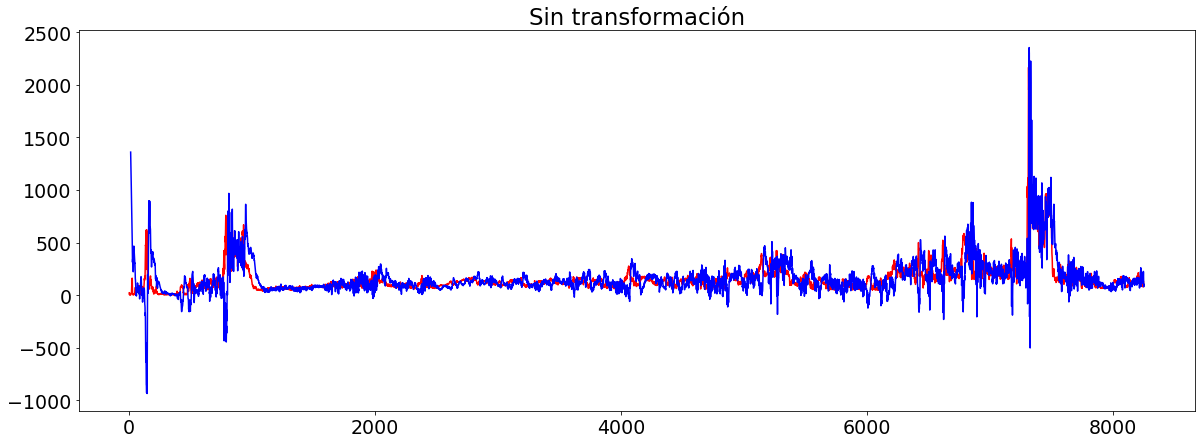

In [66]:
#Escalado
escalado = MinMaxScaler()
d=np.asarray(datos_entrenamiento['Promedio']).reshape(-1,1)
escalado.fit(d)
d=escalado.transform(d).ravel()
#Numero de rezagos
L=11
X = []
for t in range(L, len(d)):
  X.append(d[t-L:t].copy())

#Modelo Adaline
adaline = Adaline(
  learning_rate=0.027,  
  max_epochs=1,        
  shuffle=False,       
  random_state=42,    
  warm_start=False,    
  momentum=0.00004)         
  
#entrenamos el modelo 
errors2, forecasts = adaline.fit(
  X,
d[L:])
forecasts=escalado.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()
    
#Graficamos
plt.figure(figsize=(20,7))
plt.title("Sin transformación")
plt.plot(datos_entrenamiento['Promedio'], color='red');
plt.plot(range(L,len(d)), forecasts, color = 'blue');



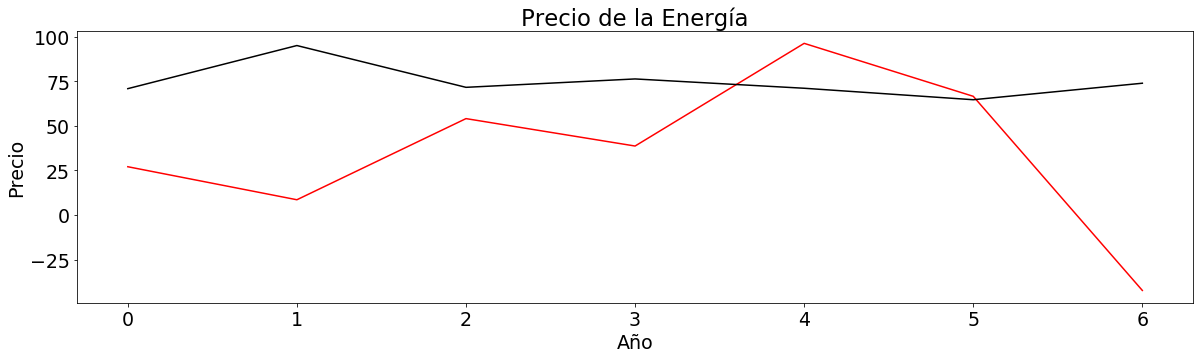

In [64]:
pronostico7Dias=[]
for proximoPronostico in range(7):
    Pronostico = adaline.predict(X[-1]) 
    proximo = np.append(X[-1][1:L], [Pronostico]) 
    X = np.concatenate( ( X, [proximo] ), axis=0)
    pronostico7Dias.append(Pronostico[0])
pronostico7Dias=escalado.inverse_transform(np.asarray(pronostico7Dias).reshape(-1,1)).ravel()
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.plot(pronostico7Dias, label="Pronóstico", color="red")
datos_pronostico = datos_pronostico.reset_index(drop=True)
plt.plot(datos_pronostico["Promedio"], label="Precio Real", color = "black")